In [14]:
import sys
sys.path.append("../") # adding the path to read the utils file
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics, tree
from imblearn.under_sampling import RandomUnderSampler
from shap import plots, Explanation, KernelExplainer
import graphviz 
from yellowbrick.model_selection import LearningCurve
import time
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pickle
import shap
from utils import *

pd.set_option('display.max_columns', None)

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# you should run making_hikari2022_csv.ipynb before running this cell, since the two csv given with the paper have two differences
# to see what are the data types and the features of the dataset, you can take a look on the utils file
ds = pd.concat([
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_hikari, usecols=selected_features_hikari),
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2022.csv', dtype=dtype_hikari, usecols=selected_features_hikari)], 
    ignore_index=True)
ds.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0,742,1826.0,121.733333,220.736581,0,1448,5025.0,358.928571,552.239840,0,1448,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,True
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0,745,1829.0,121.933333,221.339257,0,1448,5025.0,358.928571,552.239840,0,1448,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,True
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,True
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,True
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,20,40,480,32,44,2,2,2,6,5,25,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,358.928571,792.173394,0,2896,6853.0,244.750000,583.468215,16.927719,7.545305e+06,7.780620e+06,5.985092e+

In [3]:
compute_ratio(ds,'traffic_category')

                     Ratio
traffic_category          
Benign               71.77
Background           21.72
Probing               2.98
XMRIGCC CryptoMiner   1.39
Bruteforce-XML        1.12
Bruteforce            1.02


In [12]:
params = {
    'n_estimators': 64,
    'random_state': 0
}

abc = AdaBoostClassifier(**params)

rus = RandomUnderSampler(random_state=42, sampling_strategy='all')
X_res, y_res = rus.fit_resample(ds[x_features], ds['traffic_category'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state=12, shuffle=True, stratify=y_res)

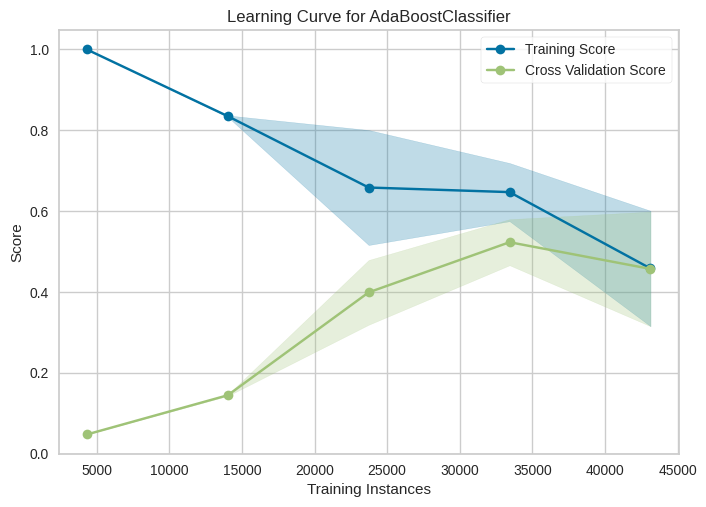

In [13]:
if True:
    # Plot the learning curve
    cv = 10
    visualizer = LearningCurve(estimator=abc, cv=cv, scoring='f1_weighted', n_jobs=-1, random_state=123)
    visualizer.fit(X_res, y_res)
    visualizer.show(outpath="abc_data/learning_curve.png")

![Alt text](abc_data/learning_curve.png)

In [15]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X_res, y_res)

5

In [16]:
avg_train_f1 = []
avg_test_f1 = []

for i, (train_index, test_index) in enumerate(skf.split(X_res, y_res)):
    print(f"Fold {i}:")
    abc.fit(X_res.iloc[train_index], y_res.iloc[train_index])
    y_predicted_train = abc.predict(X_res.iloc[train_index])
    y_predicted_test = abc.predict(X_res.iloc[test_index])
    train_f1 = metrics.f1_score(y_res.iloc[train_index], y_predicted_train, average='weighted')
    test_f1 = metrics.f1_score(y_res.iloc[test_index], y_predicted_test, average='weighted')
    print(f"Train F1: {train_f1:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    avg_train_f1.append(train_f1)
    avg_test_f1.append(test_f1)

print(f"Average Train F1: {np.mean(avg_train_f1):.4f}")
print(f"Average Test F1: {np.mean(avg_test_f1):.4f}")

Fold 0:
Train F1: 0.5629
Test F1: 0.5627
Fold 1:
Train F1: 0.7188
Test F1: 0.7209
Fold 2:
Train F1: 0.3455
Test F1: 0.3471
Fold 3:
Train F1: 0.3272
Test F1: 0.3281
Fold 4:
Train F1: 0.2261
Test F1: 0.2246
Average Train F1: 0.4361
Average Test F1: 0.4367


In [12]:
%time pv.cross_validation(ds[x_features], ds.Label, y_res)

Running the stratified 5-fold
Test and Train k-fold created
Running the cross validation
CPU times: user 1min 21s, sys: 141 ms, total: 1min 21s
Wall time: 1min 21s


(0.9298729033001628, 0.00201366128405444, 81.05432772636414)

In [13]:
%time abc.fit(X_train, y_train)

CPU times: user 16.4 s, sys: 0 ns, total: 16.4 s
Wall time: 16.4 s


AdaBoostClassifier(n_estimators=64, random_state=0)

In [14]:
%time y_predicted_train = abc.predict(X_train)
%time y_predicted_test = abc.predict(X_test)

CPU times: user 667 ms, sys: 0 ns, total: 667 ms
Wall time: 665 ms
CPU times: user 178 ms, sys: 0 ns, total: 178 ms
Wall time: 178 ms


In [15]:
performanceMetricsDF(metrics, y_train, y_predicted_train, y_test, y_predicted_test)

,Measure,Train,Test
0,ACCURACY,0.925356,0.923950
1,PRECISION,0.872818,0.871623
2,RECALL,0.995814,0.994367
3,F1 SCORE,0.930268,0.928958
4,AUC,0.925358,0.923944


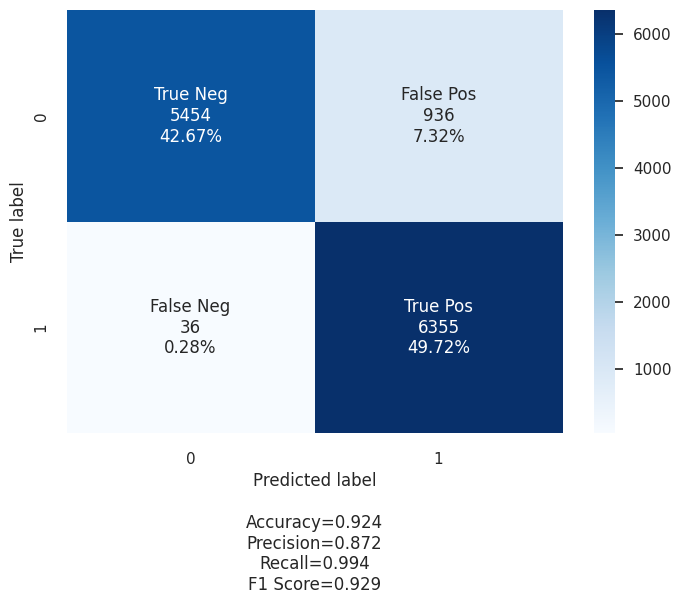

In [16]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [17]:
abc.feature_names_in_

array(['flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot',
       'fwd_data_pkts_tot', 'bwd_data_pkts_tot', 'fwd_pkts_per_sec',
       'bwd_pkts_per_sec', 'flow_pkts_per_sec', 'down_up_ratio',
       'fwd_header_size_tot', 'fwd_header_size_min',
       'fwd_header_size_max', 'bwd_header_size_tot',
       'bwd_header_size_min', 'bwd_header_size_max',
       'flow_FIN_flag_count', 'flow_SYN_flag_count',
       'flow_RST_flag_count', 'fwd_PSH_flag_count', 'bwd_PSH_flag_count',
       'flow_ACK_flag_count', 'fwd_URG_flag_count', 'bwd_URG_flag_count',
       'flow_CWR_flag_count', 'flow_ECE_flag_count',
       'fwd_pkts_payload.min', 'fwd_pkts_payload.max',
       'fwd_pkts_payload.tot', 'fwd_pkts_payload.avg',
       'fwd_pkts_payload.std', 'bwd_pkts_payload.min',
       'bwd_pkts_payload.max', 'bwd_pkts_payload.tot',
       'bwd_pkts_payload.avg', 'bwd_pkts_payload.std',
       'flow_pkts_payload.min', 'flow_pkts_payload.max',
       'flow_pkts_payload.tot', 'flow_pkts_payload.avg',
       '

In [18]:
feature_importance_dict = dict(zip(x_features, abc.feature_importances_))
important_features = [feature for feature, importance in feature_importance_dict.items() if importance > 0]
pd.DataFrame(data={'features': important_features}).to_csv('abc_data/features_used.csv')

In [19]:
for num, clf in enumerate(abc.estimators_):
    dot_data = tree.export_graphviz(clf, feature_names=x_features, out_file=None, ) 
    graph = graphviz.Source(dot_data)
    graph.render('abc_data/tree/tree_abc_' + str(num))

In [20]:
start_time = time.time()
importances = abc.feature_importances_
std = np.std([tree.feature_importances_ for tree in abc.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.005 seconds


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


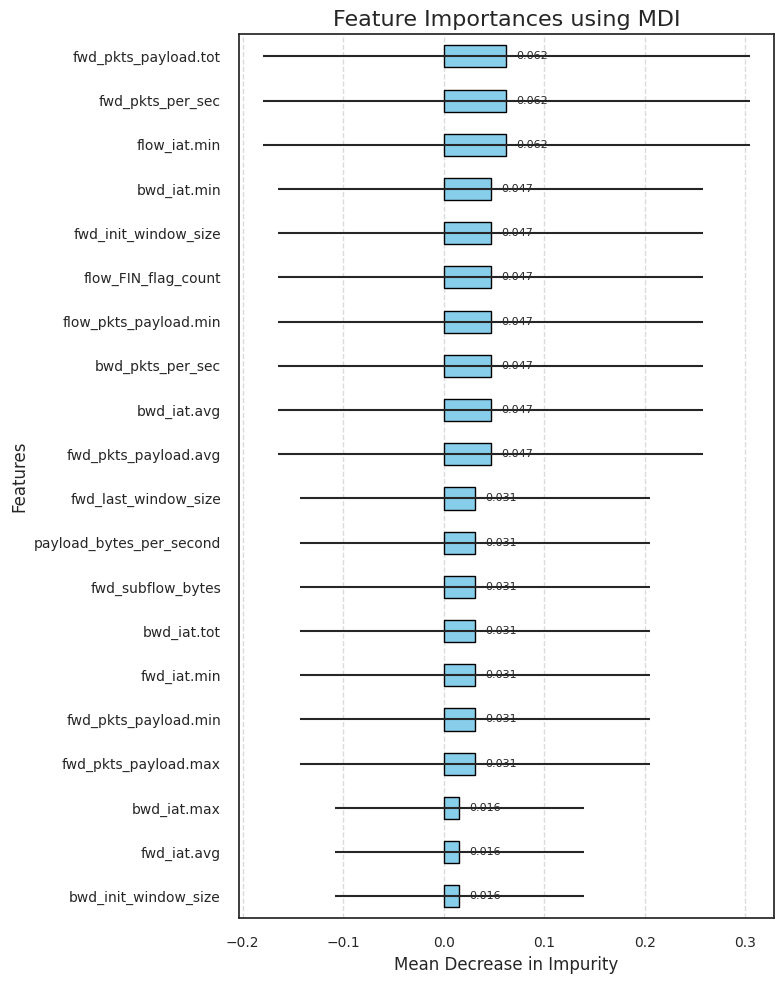

In [21]:
forest_importances = pd.Series(importances, index=x_features)

sorted_indices = np.argsort(forest_importances)[::-1]
sorted_std = std[sorted_indices][:20] # Select only the first 20 features
sorted_importance = forest_importances[sorted_indices][:20]  # Select importance values for the first 20 features

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 10))  # Adjust the figure size as needed for vertical display

# Create the vertical bar plot with error bars
sorted_importance.plot(kind='barh', xerr=sorted_std, ax=ax, color='skyblue', edgecolor='black')

# Set plot title and labels
ax.set_title("Feature Importances using MDI", fontsize=16)
ax.set_xlabel("Mean Decrease in Impurity", fontsize=12)
ax.set_ylabel("Features", fontsize=12)

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Invert y-axis to display most important feature at the top
ax.invert_yaxis()

# Add data labels at the end of each bar
for i, v in enumerate(sorted_importance):
    ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()

In [23]:
if False:
    print("making exp")
    scaler = StandardScaler()
    scaled_ds = scaler.fit_transform(X_train)

    kmeans = KMeans(n_clusters=100, random_state=0).fit(scaled_ds)

    centroids = scaler.inverse_transform(kmeans.cluster_centers_)
    
    foreground = shap.sample(X_train, 100)

    explainer = KernelExplainer(abc.predict, centroids)
    sv = explainer.shap_values(foreground)

    exp = Explanation(sv,
                  explainer.expected_value,
                  data=foreground, 
                  feature_names=x_features)

    exp.base_values = np.array([exp.base_values])

    with open('abc_data/exp.pickle', 'wb') as handle:
        pickle.dump(exp, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("loading exp")
    with open('abc_data/exp.pickle', 'rb') as handle:
        exp = pickle.load(handle)

making exp


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
100%|██████████| 100/100 [07:02<00:00,  4.23s/it]


In [24]:
if False:
    scaler = StandardScaler()
    scaled_ds = scaler.fit_transform(ds[x_features])

    kmeans = KMeans(n_clusters=100, random_state=0).fit(scaled_ds)
    centroids = scaler.inverse_transform(kmeans.cluster_centers_)

    exp_list = []

    for k in range(10):
        foreground = shap.sample(X_train, 100)

        explainer = KernelExplainer(abc.predict, centroids)
        sv = explainer.shap_values(foreground)

        exp = Explanation(sv,
                      explainer.expected_value,
                      data=foreground, 
                      feature_names=x_features)

        exp.base_values = np.array([exp.base_values])
        exp_list.append(exp)
        
    with open('abc_data/exp_list.pickle', 'wb') as handle:
        pickle.dump(exp_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("jumping the test")

jumping the test


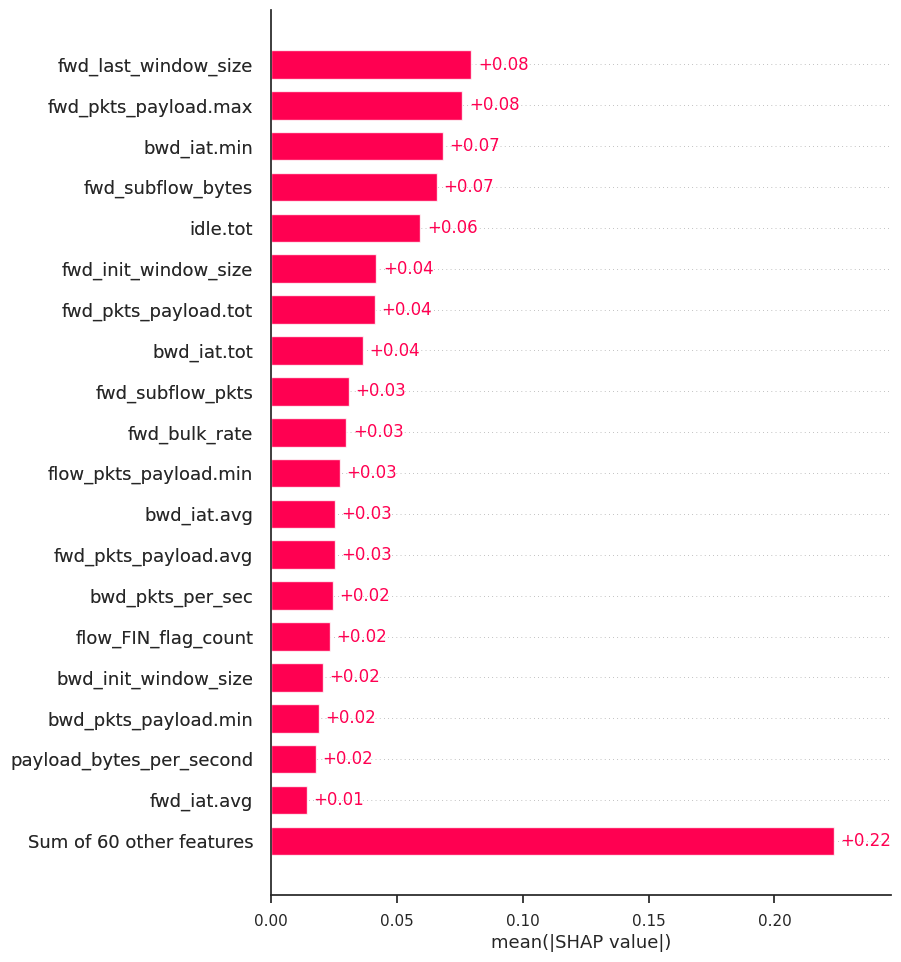

In [25]:
plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

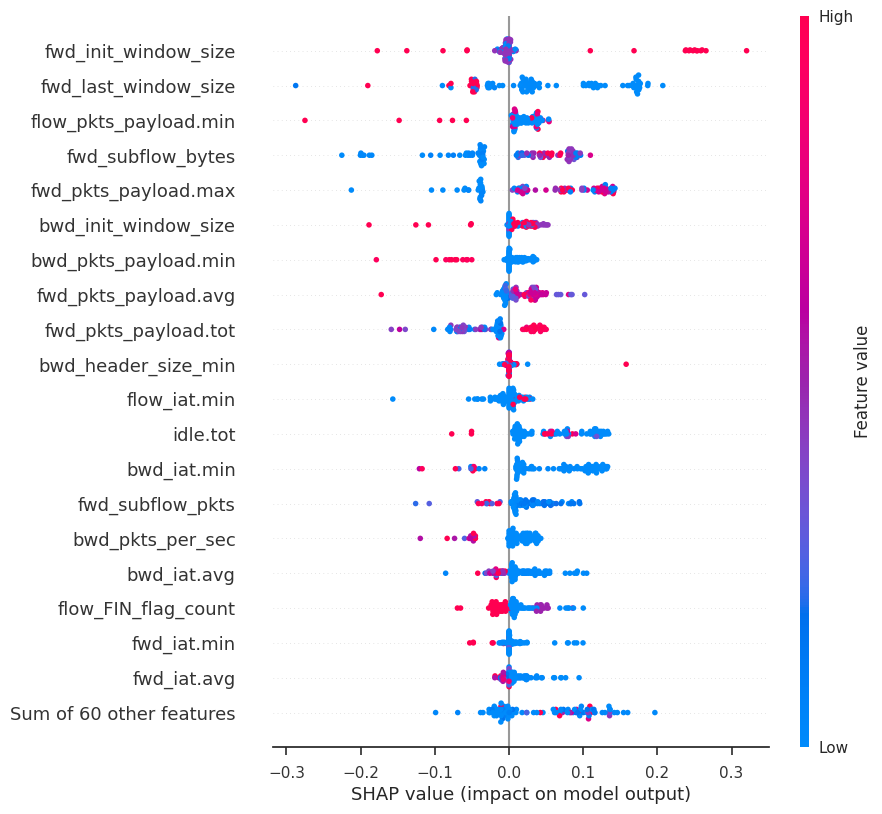

In [26]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

In [27]:
pv.feature_importance = pd.DataFrame(data={'importance' : exp.abs.mean(0).values, 'feature': x_features})
pv.feature_importance.sort_values('importance',ascending=False).head(20)

,importance,feature
78,0.079483,fwd_last_window_size
26,0.075956,fwd_pkts_payload.max
45,0.068158,bwd_iat.min
58,0.065943,fwd_subflow_bytes
73,0.059231,idle.tot
76,0.041809,fwd_init_window_size
27,0.041249,fwd_pkts_payload.tot
47,0.036405,bwd_iat.tot
56,0.030901,fwd_subflow_pkts
64,0.029888,fwd_bulk_rate


In [28]:
pv.feature_importance.to_csv('abc_data/feature_importance.csv')

In [29]:
pv.feature_above_zero = pv.feature_importance.query('importance > 0').sort_values('importance',ascending=False)['feature'].to_list()

In [30]:
%%time

if False:
    result = pv.recursive_reduction()
    feature_reduction_scores = pd.DataFrame({'F1_score': result[0], 'score_std': result[1], 'n_features': result[2], 'cv_time': result[3]})
    
    with open('abc_data/feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('abc_data/feature_reduction_scores.pickle', 'rb') as handle:
        feature_reduction_scores = pickle.load(handle)

Running the cross validation
testing with 79 features
Running the cross validation
testing with 78 features
Running the cross validation
testing with 77 features
Running the cross validation
testing with 76 features
Running the cross validation
testing with 75 features
Running the cross validation
testing with 74 features
Running the cross validation
testing with 73 features
Running the cross validation
testing with 72 features
Running the cross validation
testing with 71 features
Running the cross validation
testing with 70 features
Running the cross validation
testing with 69 features
Running the cross validation
testing with 68 features
Running the cross validation
testing with 67 features
Running the cross validation
testing with 66 features
Running the cross validation
testing with 65 features
Running the cross validation
testing with 64 features
Running the cross validation
testing with 63 features
Running the cross validation
testing with 62 features
Running the cross validation

<Axes: xlabel='n_features', ylabel='cv_time'>

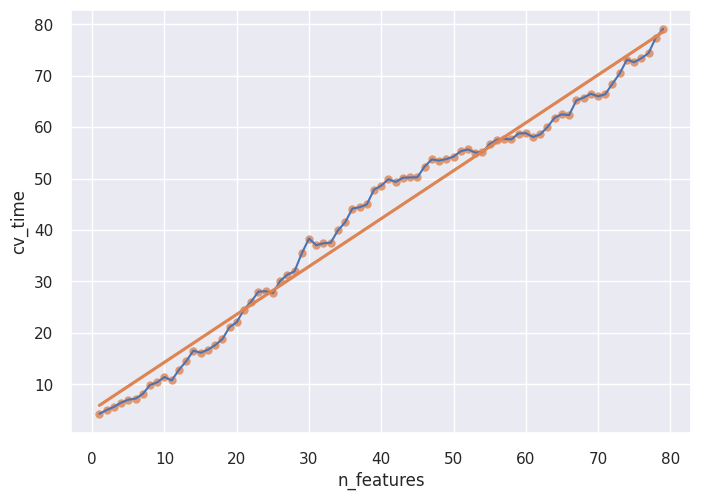

In [31]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="cv_time")
sns.regplot(data=feature_reduction_scores, x="n_features", y="cv_time", ci=None)  # ci=None removes confidence intervals

<Axes: xlabel='n_features', ylabel='F1_score'>

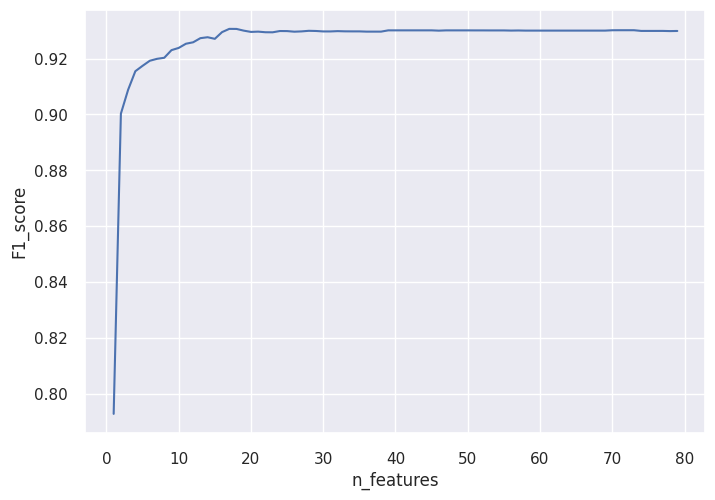

In [32]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="F1_score")

<Axes: xlabel='n_features', ylabel='score_std'>

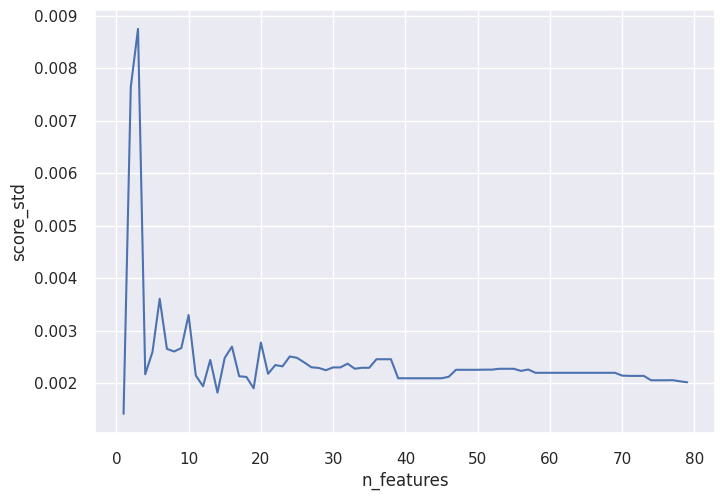

In [33]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="score_std")

In [34]:
feature_reduction_scores.sort_values('F1_score', ascending=False)

,F1_score,score_std,n_features,cv_time
62,0.930621,0.002129,17,17.603838
61,0.930601,0.002116,18,18.761682
6,0.930139,0.002136,73,70.424603
7,0.930139,0.002136,72,68.448397
8,0.930139,0.002136,71,66.390608
...,...,...,...,...
74,0.917391,0.002591,5,7.006916
75,0.915463,0.002167,4,6.433026
76,0.908814,0.008746,3,5.613045
77,0.900271,0.007641,2,5.002005


In [35]:
%%time

if False:
    zero_day_feature_reduction_scores = pv.run_zero_day_test()
    with open('abc_data/zero_day_feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(zero_day_feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('abc_data/zero_day_feature_reduction_scores.pickle', 'rb') as handle:
        zero_day_feature_reduction_scores = pickle.load(handle)

traing for  XMRIGCC CryptoMiner
training with 79 features
Running the stratified 5-fold
Test and Train k-fold created
Running the cross validation
training with 78 features
Running the cross validation
training with 77 features
Running the cross validation
training with 76 features
Running the cross validation
training with 75 features
Running the cross validation
training with 74 features
Running the cross validation
training with 73 features
Running the cross validation
training with 72 features
Running the cross validation
training with 71 features
Running the cross validation
training with 70 features
Running the cross validation
training with 69 features
Running the cross validation
training with 68 features
Running the cross validation
training with 67 features
Running the cross validation
training with 66 features
Running the cross validation
training with 65 features
Running the cross validation
training with 64 features
Running the cross validation
training with 63 features
Ru

In [36]:
# here I create this detected variable, so that we can see how many attacks are detected because only by using the mean we didn't get the best one
zero_day_feature_reduction_scores['detected'] = np.where(zero_day_feature_reduction_scores['attack_recall'] > 0, 1, 0)

In [37]:
zero_day_feature_reduction_scores.query('attack_recall != 0').sort_values('attack_recall', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
78,0.797962,1.000000,0.663841,0.791975,0.005312,1,XMRIGCC CryptoMiner,0.629060,0.087578,1
315,0.797121,0.998247,0.663450,0.792407,0.005287,1,Bruteforce-XML,0.612302,0.085164,1
236,0.792655,0.988983,0.661365,0.793892,0.005233,1,Bruteforce,0.606550,0.083764,1
301,0.418337,0.300451,0.688468,0.932097,0.002966,15,Bruteforce-XML,3.163408,0.113045,1
302,0.411549,0.295318,0.678654,0.931875,0.003483,14,Bruteforce-XML,2.928255,0.124669,1
...,...,...,...,...,...,...,...,...,...,...
144,0.000461,0.000250,0.002899,0.954690,0.002910,14,Probing,2.754578,0.117385,1
133,0.000230,0.000125,0.001422,0.955093,0.003005,25,Probing,4.746354,0.153564,1
132,0.000230,0.000125,0.001425,0.955080,0.002771,26,Probing,5.124290,0.128507,1
124,0.000230,0.000125,0.001431,0.954720,0.002995,34,Probing,6.759886,0.135790,1


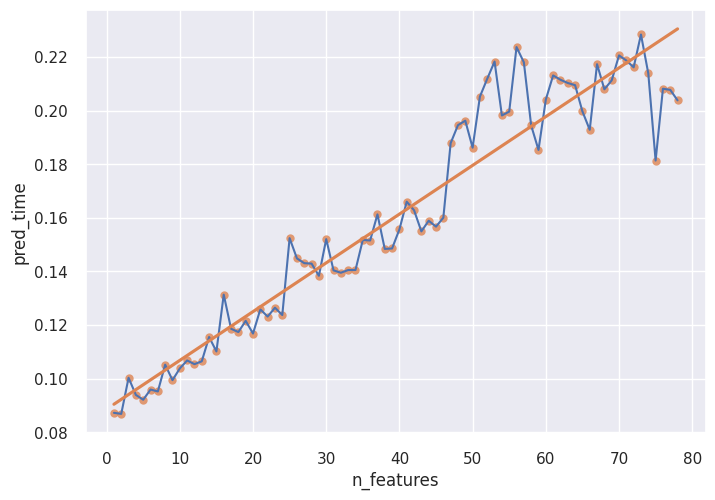

In [38]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['pred_time','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='pred_time')
    sns.regplot(data=data, x="n_features", y="pred_time", ci=None)  # ci=None removes confidence intervals

print_plot()

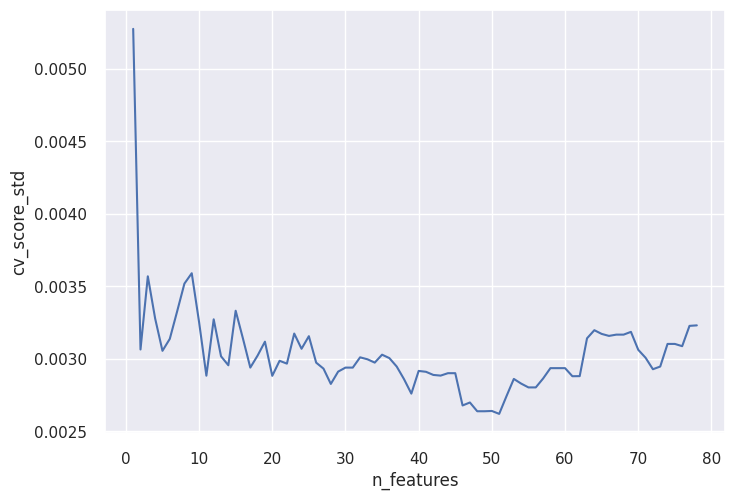

In [39]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['cv_score_std','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='cv_score_std')

print_plot()

In [40]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time', 'detected']].mean().sort_values(['attack_recall', 'attack_precision'], ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time,detected
n_features,,,,,,,,
1,0.630051,0.772628,0.543325,0.796934,0.005274,0.625565,0.087207,1.00
15,0.145027,0.099994,0.280353,0.945676,0.003331,2.819925,0.110116,0.75
12,0.142800,0.097490,0.277643,0.944419,0.003272,2.094682,0.105375,0.50
19,0.134785,0.092482,0.268502,0.947523,0.003118,3.631325,0.121534,0.75
14,0.132142,0.091418,0.256754,0.945494,0.002955,2.764908,0.115500,0.75
...,...,...,...,...,...,...,...,...
70,0.023177,0.013395,0.087217,0.947556,0.003061,13.142310,0.220572,0.75
5,0.013578,0.007981,0.045471,0.935665,0.003055,1.088899,0.092098,0.25
4,0.009349,0.005383,0.035648,0.935004,0.003277,0.976361,0.093892,0.50


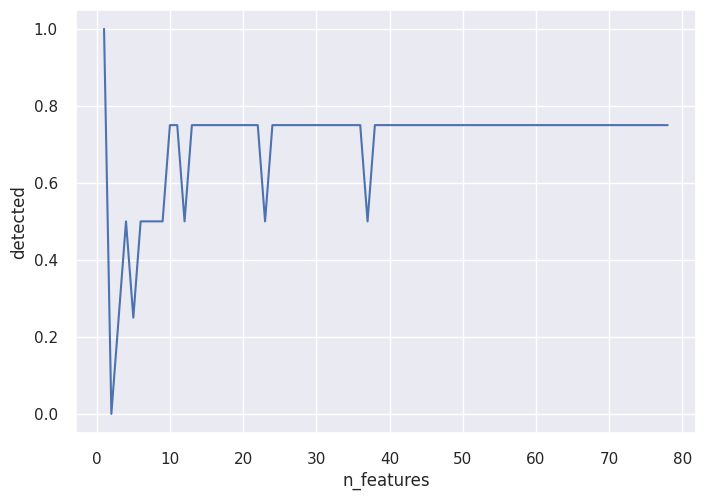

In [41]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['detected','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='detected')

print_plot()

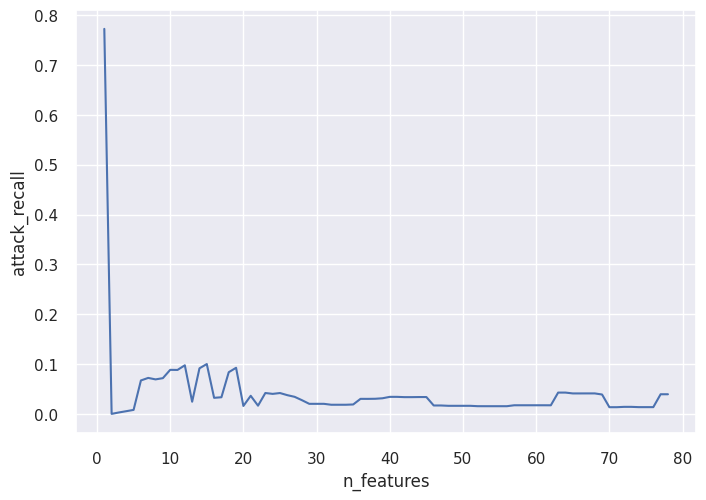

In [42]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_recall','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_recall')

print_plot()

In [43]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time']].mean().sort_values('attack_f1', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time
n_features,,,,,,,
1,0.630051,0.772628,0.543325,0.796934,0.005274,0.625565,0.087207
15,0.145027,0.099994,0.280353,0.945676,0.003331,2.819925,0.110116
12,0.142800,0.097490,0.277643,0.944419,0.003272,2.094682,0.105375
19,0.134785,0.092482,0.268502,0.947523,0.003118,3.631325,0.121534
14,0.132142,0.091418,0.256754,0.945494,0.002955,2.764908,0.115500
...,...,...,...,...,...,...,...
70,0.023177,0.013395,0.087217,0.947556,0.003061,13.142310,0.220572
5,0.013578,0.007981,0.045471,0.935665,0.003055,1.088899,0.092098
4,0.009349,0.005383,0.035648,0.935004,0.003277,0.976361,0.093892


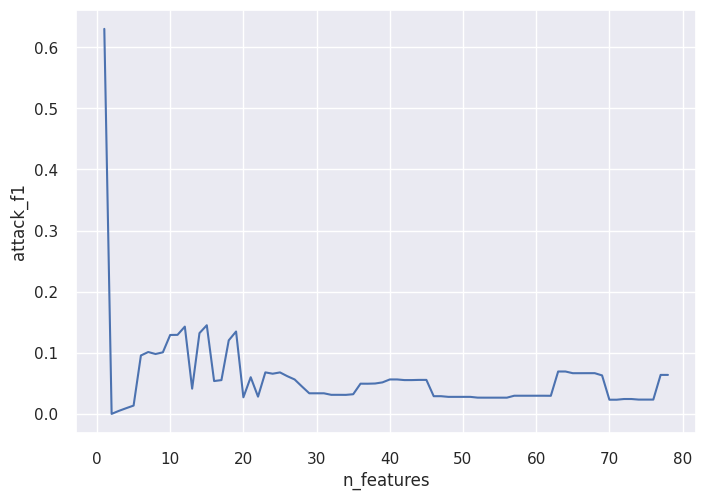

In [44]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_f1')

print_plot()

In [47]:
zero_day_feature_reduction_scores.query('n_features == 15')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
64,0.000000,0.000000,0.000000,0.962176,0.002328,15,XMRIGCC CryptoMiner,2.997402,0.113560,0
143,0.000461,0.000250,0.002899,0.954690,0.002910,15,Probing,2.676751,0.108140,1
222,0.161310,0.099274,0.430043,0.933741,0.005120,15,Bruteforce,2.442139,0.105718,1
301,0.418337,0.300451,0.688468,0.932097,0.002966,15,Bruteforce-XML,3.163408,0.113045,1
